In [59]:
import pandas as pd

In [60]:
# Load the data
file_path = '../new_dataset_raw_results.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

,Unnamed: 0,Predicted Bounding Box,Unnamed: 2,Unnamed: 3,Unnamed: 4,True Bounding Box,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Image Number,xmin,ymin,xmax,ymax,xmin,ymin,xmax,ymax
1,1,60,37,405,314,63,38,406,314
2,2,71,9,413,285,73,10,414,285
3,3,77,5,423,278,78,1,423,279
4,4,65,10,418,272,66,10,418,273


In [62]:
data.columns

Index(['Unnamed: 0', 'Predicted Bounding Box', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4', 'True Bounding Box', 'Unnamed: 6', 'Unnamed: 7',
       'Unnamed: 8'],
      dtype='object')

In [63]:
# Renaming the columns to differentiate between predicted and true bounding boxes
data.columns = ['Image Number', 
                'Pred xmin', 'Pred ymin', 'Pred xmax', 'Pred ymax', 
                'True xmin', 'True ymin', 'True xmax', 'True ymax', ]

# Check the updated dataframe to confirm changes
data.head()

,Image Number,Pred xmin,Pred ymin,Pred xmax,Pred ymax,True xmin,True ymin,True xmax,True ymax
0,Image Number,xmin,ymin,xmax,ymax,xmin,ymin,xmax,ymax
1,1,60,37,405,314,63,38,406,314
2,2,71,9,413,285,73,10,414,285
3,3,77,5,423,278,78,1,423,279
4,4,65,10,418,272,66,10,418,273


In [49]:
data_cleaned = data.drop(0)

# Reset index of the dataframe
data_cleaned.reset_index(drop=True, inplace=True)

# Rename columns appropriately
data_cleaned.columns = [
    'Image Number', 
    'Pred xmin', 'Pred ymin', 'Pred xmax', 'Pred ymax', 
    'True xmin', 'True ymin', 'True xmax', 'True ymax'
]

In [64]:
data_cleaned

,Image Number,Pred xmin,Pred ymin,Pred xmax,Pred ymax,True xmin,True ymin,True xmax,True ymax,IOU
0,1,60,37,405,314,63,38,406,314,0.984881
1,2,71,9,413,285,73,10,414,285,0.987673
2,3,77,5,423,278,78,1,423,279,0.979227
3,4,65,10,418,272,66,10,418,273,0.993386
4,5,63,10,410,257,64,12,411,256,0.982211
...,...,...,...,...,...,...,...,...,...,...
95,96,161,39,1186,873,159,41,1186,872,0.994469
96,97,173,73,1009,674,177,73,1009,671,0.990248
97,98,130,69,839,599,132,70,835,600,0.987819
98,99,196,17,1079,668,200,19,1078,669,0.989771


In [65]:
def calculate_iou(row):
    gt_box = [row['True xmin'], row['True ymin'], row['True xmax'], row['True ymax']]
    pred_box = [row['Pred xmin'], row['Pred ymin'], row['Pred xmax'], row['Pred ymax']]

    # Calculating the (x, y) coordinates of the intersection of the two boxes
    x_left = max(gt_box[0], pred_box[0])
    y_top = max(gt_box[1], pred_box[1])
    x_right = min(gt_box[2], pred_box[2])
    y_bottom = min(gt_box[3], pred_box[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0  # No overlap

    # The area of intersection
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # The areas of both bounding boxes
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])

    # The area of union
    union_area = gt_area + pred_area - intersection_area

    # Intersection over Union
    iou = intersection_area / union_area
    return iou

In [66]:
data_cleaned['IOU'] = data_cleaned.apply(calculate_iou, axis=1)

# Define a threshold for IOU to consider as a successful detection
iou_threshold = 0.75

# True Positives: detections with IOU >= threshold
true_positives = (data_cleaned['IOU'] >= iou_threshold).sum()

# False Positives: detections with IOU < threshold
false_positives = (data_cleaned['IOU'] < iou_threshold).sum()

# Assuming each image has exactly one ground truth bounding box
total_ground_truths = len(data_cleaned)  # Total number of ground truth boxes

# Precision and Recall
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / true_positives if total_ground_truths > 0 else 0
accuracy = sum(data_cleaned['IOU'])/len(data_cleaned)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')

Precision: 0.95
Recall: 1.0
Accuracy: 0.9604836971011446


In [67]:
import numpy as np
import boto3
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [85]:
from helper_code.axes_extraction import calculate_x_axis, calculate_y_axis, find_nearest_second_y_candidate, get_mean_coordinate

def get_axis(image_num, boundingBox, second_range):
    image_name = "../plot_images/"+str(image_num)+".png"

    # Initialize the Textract client
    textract = boto3.client('textract')

    # Load the image file
    with open(image_name, 'rb') as document:
        img_test = bytearray(document.read())

    # Call Amazon Textract
    response = textract.detect_document_text(Document={'Bytes': img_test})

    # Process Textract response to match desired output format
    ocr_results = []
    for item in response['Blocks']:
        if item['BlockType'] == 'LINE' and 'Confidence' in item and item['Confidence'] > 50:  # Adjust confidence as needed
            text = item['Text']
            # Extract bounding box coordinates scaled to image dimensions
            width, height = Image.open(image_name).size
            box = item['Geometry']['BoundingBox']
            x = box['Left'] * width
            y = box['Top'] * height
            w = box['Width'] * width
            h = box['Height'] * height
            box = [[x, y], [x + w, y], [x + w, y + h], [x, y + h]]
            ocr_results.append((text, box))

    # Visualization (assuming you want to visualize the results similarly)
    img = cv2.imread(image_name)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)

    for text, box in ocr_results:
        # Extract the bounding box coordinates
        start_point = box[0]
        end_point = box[2]
        box_width = end_point[0] - start_point[0]
        box_height = end_point[1] - start_point[1]
        
        # Create a Rectangle patch
        rect = patches.Rectangle(start_point, box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        
        # Annotate the image with the OCR'ed text
        ax.text(start_point[0], start_point[1] - 10, text, bbox=dict(fill=False, edgecolor='red', linewidth=2), color='red')

    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

    top_right = [boundingBox['bottomRight'][0], boundingBox['topLeft'][1]]
    bottom_right = [boundingBox['bottomRight'][0], boundingBox['bottomRight'][1]]

    rmax = find_nearest_second_y_candidate(ocr_results, top_right)
    rmin = find_nearest_second_y_candidate(ocr_results, bottom_right)

    print(rmin)
    print(rmax)

    if rmin and rmax:
        print("SECOND Y MIN", rmin["text"])
        print("SECOND Y MAX", rmax["text"])

        try:
            y_sb = float(rmin["text"])
        except ValueError:
            print("error with value on second y min")
            y_sb = float(second_range[0])

        try:
            y_sa = float(rmax["text"])
        except ValueError:
            print("error with value on second y max")
            y_sa = float(second_range[1])
        
        print("SEMANTIC SECOND Y MIN", y_sb)
        print("SEMANTIC SECOND Y MAX", y_sa)

        y_b_min = get_mean_coordinate(rmin['coords'])[1]
        y_a_max = get_mean_coordinate(rmax['coords'])[1]

        print("SECOND Y")
        print("OCR DIFF", y_a_max - y_b_min)
        print("SEM DIFF", y_sa - y_sb)
        
        ratio = (y_b_min - y_a_max)/(y_sb - y_sa)
        print("OCR RATIO", ratio)

        bounding_box_pixel_difference = boundingBox['topLeft'][1] - boundingBox['bottomRight'][1]
        real_difference = bounding_box_pixel_difference/ratio

        pixel_diff_from_base_point = (y_b_min - boundingBox['bottomRight'][1])
        print("PIXEL DIFF", pixel_diff_from_base_point)

        real_y_diff_from_base_point = pixel_diff_from_base_point/ratio 
        print("REAL DIFF FROM BASE POINT", real_y_diff_from_base_point)
        
        y_min = y_sb - real_y_diff_from_base_point
        y_max = y_min + real_difference

        print("SECOND Y_MIN", y_min)
        print("SECOND Y_MAX", y_max)

        y_range = []
        for y in [y_min, y_max]:
            if y is None or np.isnan(y) or not np.isfinite(y):
                y_range = y_sb
                print("second y is in fault condition")
                break

            y_range.append(y)


        return y_range
    else: 
        print("ERROR SECOND RANGE")
        return second_range

In [86]:
import json

IMAGE NUMBER 16


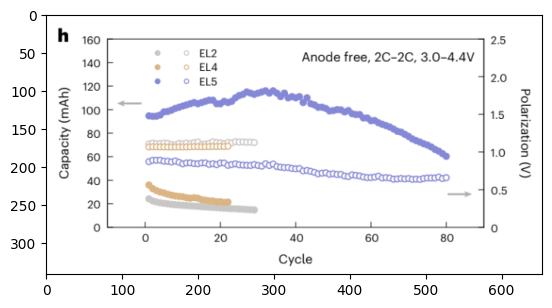

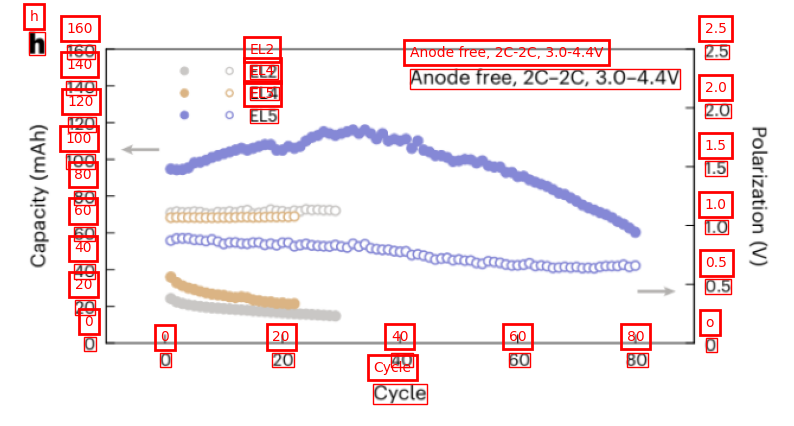

{'text': '0.5', 'coords': [[586.2701028585434, 225.77241826057434], [607.7100811824203, 225.77241826057434], [607.7100811824203, 238.1644560545683], [586.2701028585434, 238.1644560545683]]}
{'text': '2.5', 'coords': [[585.8008443117142, 28.189135372638702], [606.2418209686875, 28.189135372638702], [606.2418209686875, 40.13496670871973], [585.8008443117142, 40.13496670871973]]}
SECOND Y MIN 0.5
SECOND Y MAX 2.5
SEMANTIC SECOND Y MIN 0.5
SEMANTIC SECOND Y MAX 2.5
SECOND Y
OCR DIFF -197.8063861168921
SEM DIFF 2.0
OCR RATIO -98.90319305844605
PIXEL DIFF -48.031562842428684
REAL DIFF FROM BASE POINT 0.48564218562736206
SECOND Y_MIN 0.014357814372637945
SECOND Y_MAX 2.521860275425097
Y_RANGE [0.014357814372637945, 2.521860275425097]
IMAGE NUMBER 17


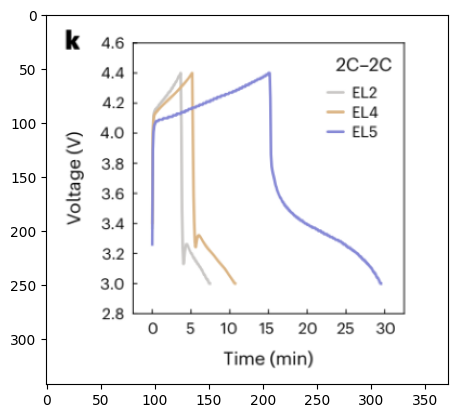

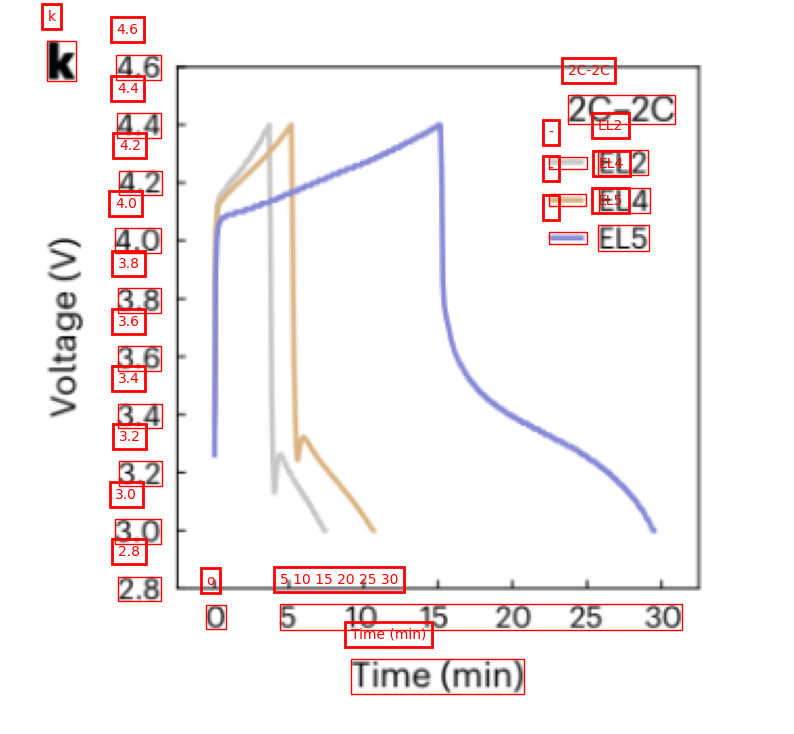

None
None
ERROR SECOND RANGE
Y_RANGE None


In [89]:
for image_num in [16, 17]:
    print("IMAGE NUMBER", image_num)
    image_name = "../plot_images/"+str(image_num)+".png"
    img = cv2.imread(image_name)
    plt.imshow(img)

    # Load JSON data into a dictionary
    with open('../results/'+str(image_num)+'/bounding_box.json', 'r') as file:
        boundingBox = json.load(file)
    
    with open('../results/'+str(image_num)+'/metadata.json') as file:
        metadata = json.load(file)
    
    y_range = get_axis(image_num, boundingBox, metadata["second-y-axis"]["range"])

    print("Y_RANGE", y_range)
    